Now something completely different -- street signs. This is a bit more real world machine vision problem as it relates to self driving cars. Lots more to self driving cars than just signs -- but you need to understand the signs!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, MaxPooling2D, MaxPooling1D, Conv2D, Reshape, Dropout
from keras.models import Model, Sequential
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import csv
import zipfile
from skimage.transform import resize

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Download signs data. This uses a bit of under the hood keras to locally cache the files.

In [2]:
training_path = keras.utils.data_utils.get_file('training.zip',
    origin='http://benchmark.ini.rub.de/Dataset/GTSRB-Training_fixed.zip')
testing_path = keras.utils.data_utils.get_file('testing.zip',
    origin='http://benchmark.ini.rub.de/Dataset/GTSRB_Online-Test-Images.zip')
testing_classes_path = keras.utils.data_utils.get_file('testing_classes.zip',
    origin='http://benchmark.ini.rub.de/Dataset/GTSRB_Online-Test-GT.zip')

These are zip files full of images, so we'll need to do some pre-processing. Need to create an (image, x, y, color) dataset of all the images, and an (image, one-hot-class) dataset of all the labels.

In [29]:
def read_image(path_to_image):
    raw_image_matrix = plt.imread(path_to_image)
    image_matrix = resize(raw_image_matrix, (32, 32), mode='constant')
    return image_matrix

def read_training_images(path_to_zip_file):
    extract_to = '{0}.d'.format(path_to_zip_file)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    images = [] # images
    labels = [] # corresponding labels
    # loop over all numbered classes
    for c in range(0, 43):
        prefix = '{0}/GTSRB/Training/{1}/'.format(extract_to, format(c, '05d'))
        with open('{0}GT-{1}.csv'.format(prefix, format(c, '05d'))) as image_annotations:
            gtReader = csv.reader(image_annotations, delimiter=';')
            next(gtReader) # skip header
            for image_data in gtReader:
                # the 1th column is the filename
                images.append(read_image('{0}{1}'.format(prefix, image_data[0]))) 
                # the 8th column is the label
                labels.append(image_data[7]) 

    return np.asarray(images), keras.utils.to_categorical(labels, 43)

In [30]:
train_images, train_labels = read_training_images(training_path)

Let's take a peek at these images and get a sense of the shape.

(26640, 32, 32, 3)

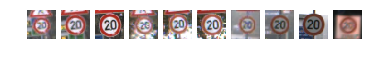

In [31]:
fig = plt.figure()
for i in range(0, 10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(train_images[i*10])
    plt.axis('off')
train_images.shape

Here is a simple convolutional network with pooling and a dense output.

In [7]:
help(resize)

Help on function resize in module skimage.transform._warps:

resize(image, output_shape, order=1, mode=None, cval=0, clip=True, preserve_range=False)
    Resize image to match a certain size.
    
    Performs interpolation to up-size or down-size images. For down-sampling
    N-dimensional images by applying a function or the arithmetic mean, see
    `skimage.measure.block_reduce` and `skimage.transform.downscale_local_mean`,
    respectively.
    
    Parameters
    ----------
    image : ndarray
        Input image.
    output_shape : tuple or ndarray
        Size of the generated output image `(rows, cols[, dim])`. If `dim` is
        not provided, the number of channels is preserved. In case the number
        of input channels does not equal the number of output channels a
        3-dimensional interpolation is applied.
    
    Returns
    -------
    resized : ndarray
        Resized version of the input.
    
    Other parameters
    ----------------
    order : int, optional


In [5]:
input_shape = x_train[0].shape


model = Sequential()
model.add(Reshape(input_shape, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, train_labels,
          batch_size=64,
          epochs=8,
          validation_data=(x_test, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 11s 188us/step - loss: 0.1350 - acc: 0.9590 - val_loss: 0.0490 - val_acc: 0.9843
Epoch 2/8
60000/60000 [==============================] - 8s 135us/step - loss: 0.0401 - acc: 0.9877 - val_loss: 0.0437 - val_acc: 0.9864
Epoch 3/8
60000/60000 [==============================] - 8s 137us/step - loss: 0.0252 - acc: 0.9919 - val_loss: 0.0339 - val_acc: 0.9893
Epoch 4/8
60000/60000 [==============================] - 8s 130us/step - loss: 0.0181 - acc: 0.9942 - val_loss: 0.0448 - val_acc: 0.9879
Epoch 5/8
60000/60000 [==============================] - 8s 131us/step - loss: 0.0136 - acc: 0.9954 - val_loss: 0.0369 - val_acc: 0.9880
Epoch 6/8
60000/60000 [==============================] - 8s 132us/step - loss: 0.0125 - acc: 0.9959 - val_loss: 0.0463 - val_acc: 0.9866
Epoch 7/8
60000/60000 [==============================] - 8s 131us/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0393 - val_ac

Now -- look at the gap between the acc and val_acc -- that's the overfitting.

Now, let's try the same model but with L2 regularization. This applies a penalty function, you can think of it as a kind of additional loss. The benefit is -- less overfitting.

In [6]:
kernel_regularizer=regularizers.l2(0.01)

regularized = Sequential()
regularized.add(Reshape(input_shape, input_shape=input_shape))
regularized.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=kernel_regularizer))
regularized.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=kernel_regularizer))
regularized.add(MaxPooling2D(pool_size=(2, 2)))
regularized.add(Flatten())
regularized.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
regularized.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
regularized.add(Dense(10, activation='softmax'))


regularized.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
regularized.fit(x_train, train_labels,
          batch_size=64,
          epochs=8,
          validation_data=(x_test, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 9s 150us/step - loss: 0.8421 - acc: 0.9156 - val_loss: 0.4289 - val_acc: 0.9555
Epoch 2/8
60000/60000 [==============================] - 8s 141us/step - loss: 0.3939 - acc: 0.9495 - val_loss: 0.3622 - val_acc: 0.9459
Epoch 3/8
60000/60000 [==============================] - 8s 138us/step - loss: 0.3274 - acc: 0.9569 - val_loss: 0.3043 - val_acc: 0.9574
Epoch 4/8
60000/60000 [==============================] - 8s 139us/step - loss: 0.3054 - acc: 0.9593 - val_loss: 0.2781 - val_acc: 0.9656
Epoch 5/8
60000/60000 [==============================] - 8s 139us/step - loss: 0.2888 - acc: 0.9609 - val_loss: 0.2684 - val_acc: 0.9645
Epoch 6/8
60000/60000 [==============================] - 8s 142us/step - loss: 0.2775 - acc: 0.9625 - val_loss: 0.2482 - val_acc: 0.9678
Epoch 7/8
60000/60000 [==============================] - 9s 142us/step - loss: 0.2707 - acc: 0.9615 - val_loss: 0.2355 - val_acc

You can see the model is slower to learn, comparing the smaller initial accuracy and larger loss compared to the non-regularized prior run. This higher loss is simply less overfitting to the training data.

And -- look at the result -- the `val_acc` is actually higher than the `acc`, which while less accurate -- has led our model to be more generalized, which is to say -- less memorized on the training data.

This is an interestind tradeoff -- but can be overcome with more training data and more epochs of training!

Now, a different approach -- *Dropout*. This will randomly deactive individual parameters while training, but not while validating or predicting. The notion is that the network is forced to adapt to the data and generalize as it cannot rely on which parameters will be active in any given training run.

We'll add a 50% dropout after each learning layer.

In [7]:

dropped = Sequential()
dropped.add(Reshape(input_shape, input_shape=input_shape))
dropped.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.5))
dropped.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.5))
dropped.add(MaxPooling2D(pool_size=(2, 2)))
dropped.add(Flatten())
dropped.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.5))
dropped.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.5))
dropped.add(Dense(10, activation='softmax'))


dropped.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dropped.fit(x_train, train_labels,
          batch_size=64,
          epochs=8,
          validation_data=(x_test, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 11s 176us/step - loss: 1.2239 - acc: 0.8211 - val_loss: 0.5980 - val_acc: 0.9546
Epoch 2/8
60000/60000 [==============================] - 10s 165us/step - loss: 0.6569 - acc: 0.9033 - val_loss: 0.4828 - val_acc: 0.9607
Epoch 3/8
60000/60000 [==============================] - 10s 166us/step - loss: 0.5933 - acc: 0.9141 - val_loss: 0.4530 - val_acc: 0.9634
Epoch 4/8
60000/60000 [==============================] - 10s 167us/step - loss: 0.5658 - acc: 0.9168 - val_loss: 0.4420 - val_acc: 0.9631
Epoch 5/8
60000/60000 [==============================] - 10s 166us/step - loss: 0.5508 - acc: 0.9169 - val_loss: 0.4362 - val_acc: 0.9589
Epoch 6/8
60000/60000 [==============================] - 10s 165us/step - loss: 0.5367 - acc: 0.9206 - val_loss: 0.4136 - val_acc: 0.9645
Epoch 7/8
60000/60000 [==============================] - 10s 167us/step - loss: 0.5286 - acc: 0.9221 - val_loss: 0.3947 - 

And -- again, a slower learning rate, but better generalization. Dropout is a bit easier to understand than L2 regularization, which is a bit *math-y*, and interacts with the loss function and learning rate. It can be difficult to reason about parameter values.

Dropout is simpler, you can vary the dropout effect by choosing different percentages, and more training loops. Here it is with 20%.

In [8]:
dropped = Sequential()
dropped.add(Reshape(input_shape, input_shape=input_shape))
dropped.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.2))
dropped.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.2))
dropped.add(MaxPooling2D(pool_size=(2, 2)))
dropped.add(Flatten())
dropped.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.2))
dropped.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
dropped.add(Dropout(0.2))
dropped.add(Dense(10, activation='softmax'))


dropped.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dropped.fit(x_train, train_labels,
          batch_size=64,
          epochs=8,
          validation_data=(x_test, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 11s 179us/step - loss: 0.9120 - acc: 0.9033 - val_loss: 0.4685 - val_acc: 0.9569
Epoch 2/8
60000/60000 [==============================] - 10s 168us/step - loss: 0.4515 - acc: 0.9417 - val_loss: 0.3627 - val_acc: 0.9663
Epoch 3/8
60000/60000 [==============================] - 10s 168us/step - loss: 0.4030 - acc: 0.9481 - val_loss: 0.3515 - val_acc: 0.9619
Epoch 4/8
60000/60000 [==============================] - 10s 167us/step - loss: 0.3844 - acc: 0.9481 - val_loss: 0.3427 - val_acc: 0.9676
Epoch 5/8
60000/60000 [==============================] - 10s 168us/step - loss: 0.3678 - acc: 0.9512 - val_loss: 0.3149 - val_acc: 0.9707
Epoch 6/8
60000/60000 [==============================] - 10s 163us/step - loss: 0.3555 - acc: 0.9519 - val_loss: 0.3182 - val_acc: 0.9634
Epoch 7/8
60000/60000 [==============================] - 10s 167us/step - loss: 0.3470 - acc: 0.9531 - val_loss: 0.3092 - 

That's a pretty good compromise!